In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
orig_df = df
agg = (
     df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index()
)
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]
agg_df = df.merge(agg, on="cabin")

In [4]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[
        :, num_cols
    ] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(
        X_test[num_cols]
    )

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[
            :, std_cols
        ] = std.fit_transform(
            X_train[std_cols]
        )
        X_test.loc[
            :, std_cols
        ] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

-

In [5]:
limit = 0.95
corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

Text(0.5, 0.98, 'Mapa korelacji między cechami')

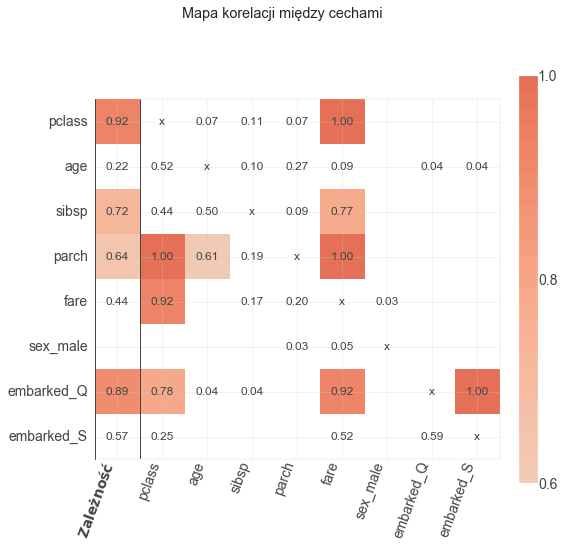

In [177]:
import rfpimp
data = rfpimp.feature_dependence_matrix(X_train)
data.columns.values[0]="Zależność"
rfpimp.plot_dependence_heatmap(
    data,
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()
fig.suptitle('Mapa korelacji między cechami')
# fig.savefig(
#     "images/mlpr_0801.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [21]:
from sklearn.ensemble import RandomForestClassifier
cols_to_remove = [
    "pclass",
    "sibsp",
    "parch",
    "embarked_Q",
]
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)
rf3.score(
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
)
rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7659033078880407

Text(0.5, 1.0, 'Współczynniki cech w regresji lasso')

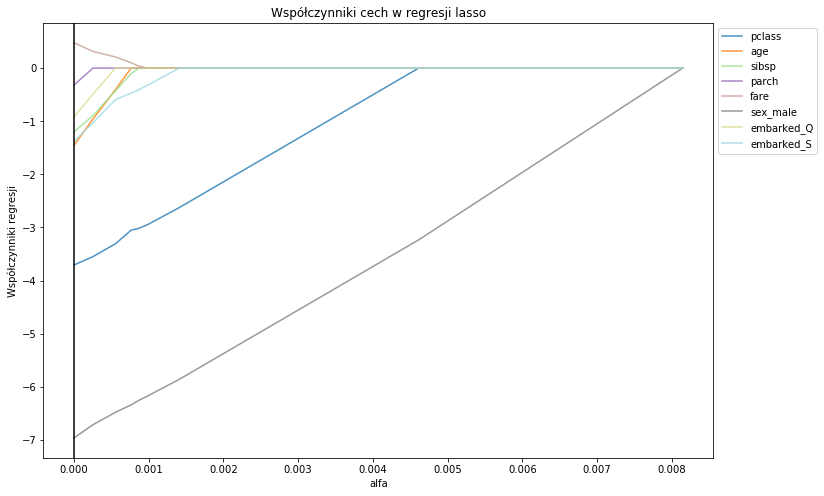

In [23]:
from sklearn import linear_model
model = linear_model.LassoLarsCV(
    cv=10, max_n_alphas=10
).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(12, 8))
cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X.shape[1])
    )
)
for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )
ax.axvline(
    model.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)
plt.ylabel("Współczynniki regresji")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alfa")
plt.title("Współczynniki cech w regresji lasso")
# fig.savefig(
#     "images/mlpr_0802.png",
#     dpi=300,
#     bbox_inches="tight",
# )

array([ True,  True, False, False,  True,  True, False, False])

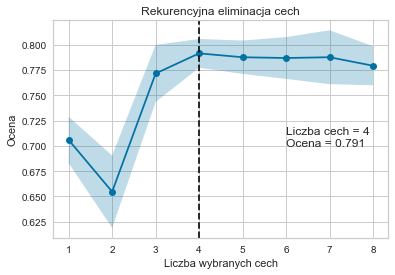

In [170]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5
)
rfe.fit(X, y)
rfe.ax.set(xlabel="Liczba wybranych cech", ylabel="Ocena", title="Rekurencyjna eliminacja cech")
rfe.ax.text(6, 0.7, 
            "Liczba cech = {}\nOcena = {:0.3f}".format(rfe.rfe_estimator_.n_features_, rfe.cv_scores_.mean(axis=1).max())
           )
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
# fig.savefig("images/mlpr_0803.png", dpi=300)

In [112]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model, 4)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

Text(0.5, 1.0, 'Informacja wzajemna')

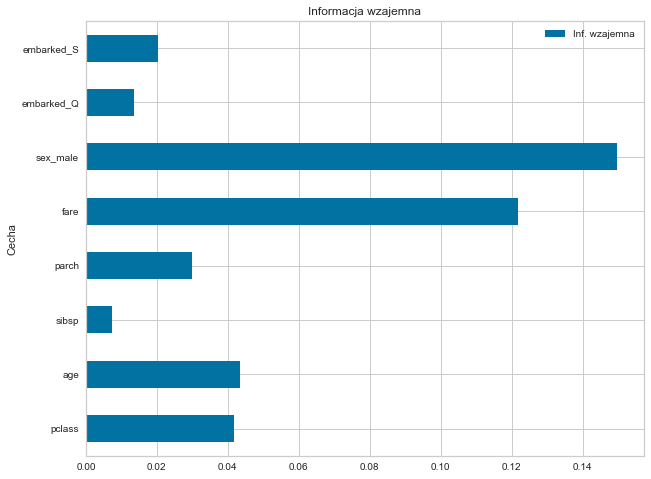

In [171]:
from sklearn import feature_selection
mic = feature_selection.mutual_info_classif(
    X, y
)
fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"Cecha": X.columns, "Inf. wzajemna": mic}
    )
    .set_index("Cecha")
    .plot.barh(ax=ax)
)
ax.set_title("Informacja wzajemna")
# fig.savefig("images/mlpr_0804.png")